In [1]:
# Imports
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../../sra.h5', mode='r')

last updated: 2017-11-02 
Git hash: 77256d4c91158a79506f4adb8e290ae30d5f9ec0


In [53]:
# Constants
LIBSIZE_CUTOFF = 1e5      # 100,000 reads
READLEN_CUTOFF = 30       # 30 bp
STRAND_CUTOFF1 = 0.75     # 75% stranded reads
STRAND_CUTOFF2 = 0.95     # 95% stranded reads
MAPPING_CUTOFF = 0.30     # 30% Uniquely mapping
CONTAMINATION_CUTOFF = 40 # 50% reads mapping to DM6

REFERENCES = [
    'adapters', 
    'phix', 
    'ercc', 
    'dm6', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

# Pre-Alignment Workflow and Quality Control

Here we used data to discover the technical metadata as well as performing quality assurance to select samples to process.

## Library Size

Sequencing technologies have changed a lot in the past 5 years. There has been a substantial increase in the number of reads produced by a single sequencing run, and an increase in the number of bases that can be sequenced. During the pre-pre-alignment workflow I estimate library size and calculate the average read length. I would like to remove overtly low quality samples that have a small number of reads and reads that are very short. 

Here I look at these distributions and I can see that most samples have more than 1 million reads. There is a small number of samples (~2k) that have fewer than 100,000 reads. I have decided to flag these samples as having a low library size.

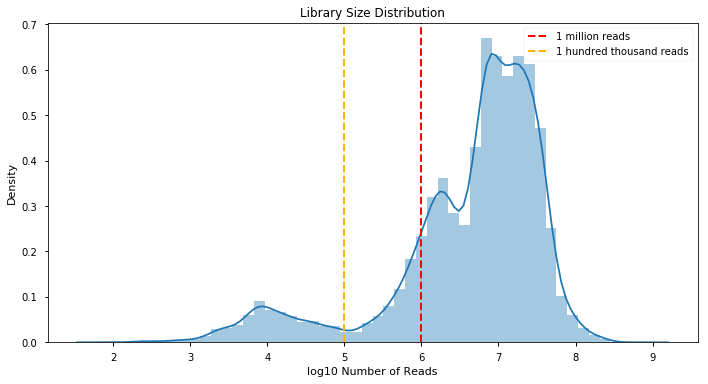

In [5]:
# Plot distribution of libsizes
@make_figs(nbconfig.fig_name('distplot_libsize'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['srx', 'srr', 'libsize_R1']]
    fig, ax = plt.subplots(1, 1)
    sns.distplot(np.log10(df.libsize_R1), ax=ax)
    ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1 million reads')
    ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='1 hundred thousand reads')
    ax.legend()
    ax.set_xlabel('log10 Number of Reads')
    ax.set_ylabel('Density')
    ax.set_title('Library Size Distribution');
    return fig

plot(store)

In [6]:
# Make flags
from ncbi_remap.flagging import libsize
libsize_ok = libsize(store, cutoff=LIBSIZE_CUTOFF)
print('There are {:,} samples with more than {:,.0f} reads.'.format(libsize_ok.shape[0], LIBSIZE_CUTOFF))

There are 20,828 samples with more than 100,000 reads.


## Read Length

I looked at the average read length and found that most samples either have a read length of 50 or 75-100 bp. There are ~700 samples that have an average read length less than 30. Note the alignment pipeline throws out individual reads that are ≤20 bp.

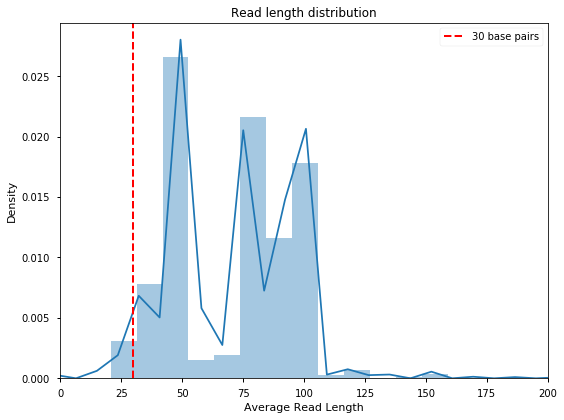

In [7]:
# Plot distirubtion of read lengths
@make_figs(nbconfig.fig_name('distplot_readLen'), 
           styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['srx', 'srr', 'avgLen_R1', 'avgLen_R2']]
    df['len'] = df[['avgLen_R1', 'avgLen_R2']].max(axis=1)

    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.len, bins=100, ax=ax)
    ax.set_xlabel('Average Read Length')
    ax.set_ylabel('Density')
    ax.set_xlim(0, 200)
    ax.set_title('Read length distribution');
    ax.axvline(READLEN_CUTOFF, ls='--', lw=2, color='r', label='{} base pairs'.format(READLEN_CUTOFF))
    ax.legend()
    
    return fig

plot(store)

In [8]:
# Make flags
from ncbi_remap.flagging import readlen
readlen_ok = readlen(store, cutoff=READLEN_CUTOFF)
print('There are {:,} samples with realengths ≥{}'.format(readlen_ok.shape[0], READLEN_CUTOFF))

There are 22,938 samples with realengths ≥30


## Stranded

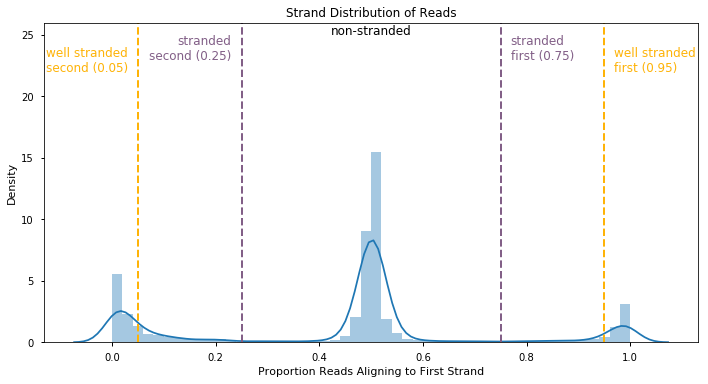

In [9]:
# Plot distribution of strandedness
@make_figs(nbconfig.fig_name('distplot_strandedness'), styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/collectrnaseqmetrics/first']
    c1 = sns.xkcd_rgb['dusty purple']
    c2 = sns.xkcd_rgb['amber']
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.PCT_CORRECT_STRAND_READS, ax=ax)
    ax.set_title('Strand Distribution of Reads')
    ax.set_xlabel('Proportion Reads Aligning to First Strand')
    ax.set_ylabel('Density')
    ax.axvline(STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(1 - STRAND_CUTOFF1, ls='--', lw=2, color=c1)
    ax.axvline(STRAND_CUTOFF2, ls='--', lw=2, color=c2)
    ax.axvline(1 - STRAND_CUTOFF2, ls='--', lw=2, color=c2)

    _ct1 = STRAND_CUTOFF1
    _ct2 = 1 - STRAND_CUTOFF1
    ax.annotate(xy=(_ct1, 23), s='stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c1)
    ax.annotate(xy=(_ct2, 23), s='stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c1)

    _ct1 = STRAND_CUTOFF2
    _ct2 = 1 - STRAND_CUTOFF2
    ax.annotate(xy=(_ct1, 22), s='well stranded\nfirst ({:.2f})'.format(_ct1), xytext=(10, 0), textcoords='offset points', color=c2)
    ax.annotate(xy=(_ct2, 22), s='well stranded\nsecond ({:.2f})'.format(_ct2), ha='right', xytext=(-10, 0), textcoords='offset points', color=c2)

    ax.annotate(xy=(.5, 25), s='non-stranded', ha='center', color='k')
    ax.set_ylim(0, 26)
    return fig

plot(store)

In [10]:
# Make flags
from ncbi_remap.flagging import strandedness

def pout(c, f, s, u):
    print("""\
    Cutoff: {:0.2f}
    First Strand: {:,}
    Second Strand: {:,}
    Unstranded: {:,}
    """.format(c, f.shape[0], s.shape[0], u.shape[0]))

f1, s1, u1 = strandedness(store, cutoff=STRAND_CUTOFF1)
pout(STRAND_CUTOFF1, f1, s1, u1)

f2, s2, u2 = strandedness(store, cutoff=STRAND_CUTOFF2)
pout(STRAND_CUTOFF2, f2, s2, u2)

    Cutoff: 0.75
    First Strand: 2,720
    Second Strand: 5,633
    Unstranded: 14,584
    
    Cutoff: 0.95
    First Strand: 2,117
    Second Strand: 3,948
    Unstranded: 16,872
    


## Mapability

One important quality metric is how well reads align to the genome. Here we look at the overall mapping quality and see if there are any criteria which would require filtering of low quality samples. A sample may have a low unique mapping if that sample is contaminated or has low sequence complexity. There is a distinct distribution patter when looking at the distribution of proportion of unique mapping reads. This distribution resembles a normal distribution with a extremely fat tail on the lower end of values. The natural inflection point is around 0.3 or 0.35. Here I selected a quality cutoff of 0.3 (30% reads mapping uniquely).

Next I was interested in seeing if SRRs within an SRX have similar mapability. An SRR is supposed to be a technical replicate of an SRX. It is possible that if an SRX has highly variable SRRs that it may be made up of different libraries. There are other feature sets that I will explore regarding these relationships, here I just quickly look at the standard deviation of SRRs within an SRX. In general, the distribution looks almost normally distributed with a slight left skew toward smaller STDs as expected. By far the worst sample was (SRX352887: SRR989483) which had only 3 reads mapping uniquely, suggesting a contamination problem.

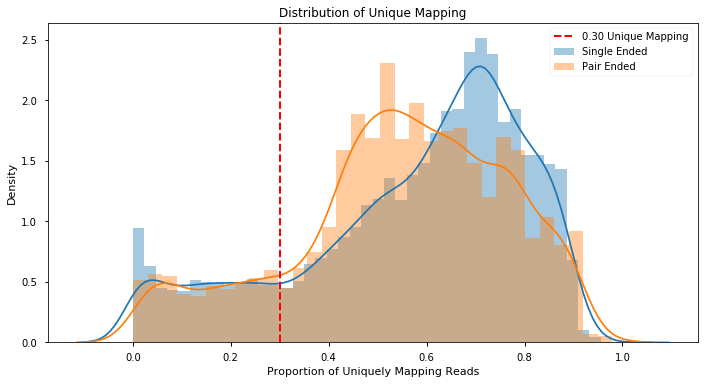

In [11]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_unique_mapping'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    se = store['prealn/workflow/hisat2/SE'][['srx', 'srr', 'num_reads', 'num_uniquely_aligned']]
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']

    pe = store['prealn/workflow/hisat2/PE'][['srx', 'srr', 'num_reads', 'num_concordant_reads_uniquely_aligned']]
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_unique_aligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_unique_aligned, ax=ax, label='Pair Ended')
    ax.axvline(MAPPING_CUTOFF, color='r', ls='--', lw=2, label='{:0.2f} Unique Mapping'.format(MAPING_CUTOFF))
    ax.legend()
    ax.set_title('Distribution of Unique Mapping')
    ax.set_xlabel('Proportion of Uniquely Mapping Reads')
    ax.set_ylabel('Density');
    
plot(store)

In [12]:
# Make flags
from ncbi_remap.flagging import mappability
mapping_ok = mappability(store, cutoff=MAPPING_CUTOFF)
print('There are {:,} samples with ≥{:0.0f}% reads mapping uniquely.'.format(mapping_ok.shape[0], MAPPING_CUTOFF * 100))

There are 19,375 samples with ≥30% reads mapping uniquely.


## Contamination

I am worried about several potential forms of contamination. First I am worried that submitters may have misidentified their submission as D. melanogaster. Second I want to identify samples that have specific contaminations from other species, which could be caused by actual sample contamination or because samples were mixed with another species as a form of multiplexing. Finally, this metric can identify large fractions of reads aligning to rRNA which could indicate a failed poly(A) selection or ribo subtraction, or possibly that the library was constructed in some non-standard way.

Fastq Screen was used to look for sources of contamination. Here I aligned untrimmed FASTQs to different reverences. References were technical (Adapters, ERCC, PhiX) and biological (dm6, dm6-rRNA, ecoli, hg19, wolbachia, yeast) in nature. Fastq screen summarizes reads into different classes based on if reads align to a single or multiple locations within a references and if they align to a single or multiple references. Different classes of counts can be used to look for different types of problems. For example, a sample with a high percentage of "one hit one library" aligning to hg19 would indicate that the sample was either human in nature or mixed with human samples. Similarly, looking at "multiple hit multiple libraries" reads that also align to rRNA can be used to identify rRNA contamination.

### One Hit One Library (Contamination)

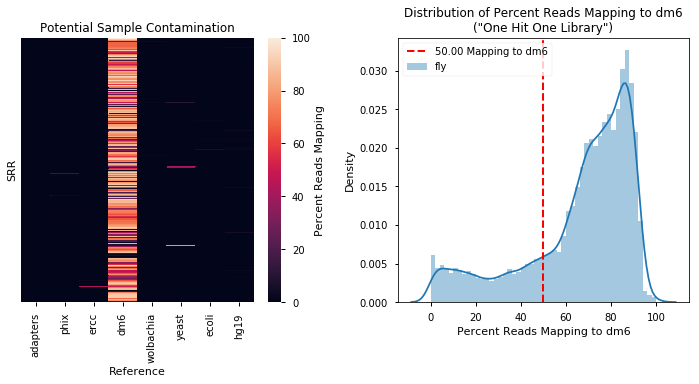

In [47]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('heatmap_distplot_contamination'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(df[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
    ax1.set_title('Potential Sample Contamination');
    ax1.set_ylabel('SRR');
    ax1.set_xlabel('Reference');

    # Plot distirbution of major categories
    sns.distplot(df.dm6, label='fly', ax=ax2)
    plt.title('Distribution of Percent Reads Mapping to dm6\n("One Hit One Library")');
    ax2.set_xlabel('Percent Reads Mapping to dm6')
    ax2.set_ylabel('Density')
    ax2.axvline(CONTAMINATION_CUTOFF, color='r', ls='--', lw=2, 
                label='{:0.2f} Mapping to dm6'.format(CONTAMINATION_CUTOFF))
    ax2.legend()
    
    return fig

plot(store)

In [15]:
# Create summary table showing the number of samples whose majority of 
# reads came from a specific reference.
def summary(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)

    table = df.apply(lambda x: x.argmax(), axis=1).value_counts()
    table['total'] = table.sum()
    table = table.map(lambda x: '{:,}'.format(x)).to_frame()

    table.columns = ['Number of Samples']
    
    return table

summary(store)

,Number of Samples
dm6,"22,596"
yeast,204
hg19,50
ercc,36
adapters,17
rRNA,11
phix,11
ecoli,9
wolbachia,4
total,"22,938"


In [54]:
# Make flags
from ncbi_remap.flagging import contamination
contamination_ok = contamination(store, cutoff=CONTAMINATION_CUTOFF)
print('There are {:,} samples with ≥{:0.0f}% '
      'reads mapping to D. melanogaster.'.format(
          contamination_ok.shape[0], CONTAMINATION_CUTOFF
      )
)

There are 19,392 samples with ≥40% reads mapping to D. melanogaster.


### rRNA Over-representation

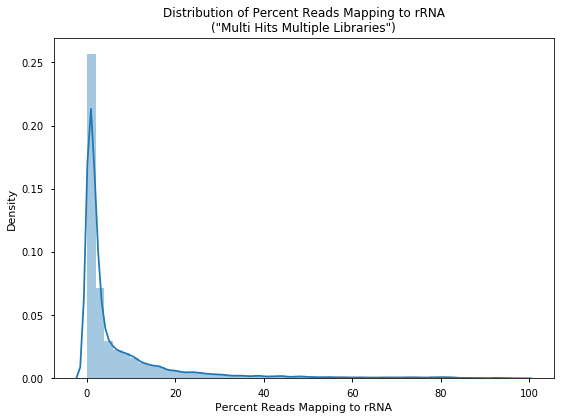

In [16]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('distplot_rRNA_overrep'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df = df[['srx', 'srr', 'reference', 'multiple_hits_multiple_libraries_percent']].set_index(['srx', 'srr', 'reference']).unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.rRNA, ax=ax)
    ax.set_title('Distribution of Percent Reads Mapping to rRNA\n("Multi Hits Multiple Libraries")');
    ax.set_xlabel('Percent Reads Mapping to rRNA')
    ax.set_ylabel('Density')
    
    return fig

plot(store)

## QC Flags

In [55]:
ok_samples = libsize_ok.merge(
    readlen_ok, on=['srx', 'srr'], how='inner').merge(
    mapping_ok, on=['srx', 'srr'], how='inner').merge(
    contamination_ok, on=['srx', 'srr'], how='inner')

In [56]:
print('There are {:,} samples that pass all set criteria.'.format(ok_samples.shape[0]))

There are 17,140 samples that pass all set criteria.


# Merging SRXs

## Number of SRRs Per SRX

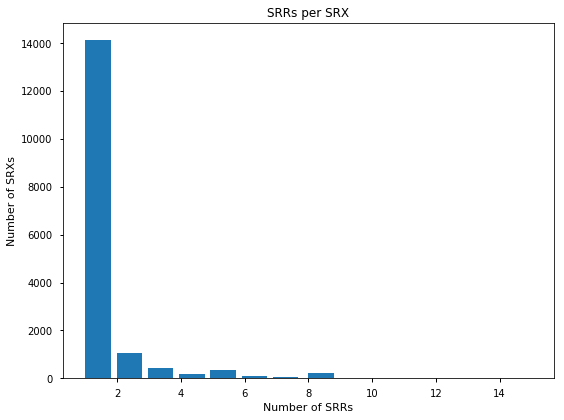

In [3]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/complete'].groupby('srx').count()
    fig, ax = plt.subplots(1, 1)
    df.hist(bins=100, width=.8, grid=False, ax=ax)
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    return fig

plot(store)

In [4]:
# Make Flags
from ncbi_remap.flagging import srr_per_srx
srx_counts = srr_per_srx(store)
multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

print('There are {:,} SRXs that have more than 1 SRR.'.format(len(multi_srr_srx)))

There are 2,390 SRXs that have more than 1 SRR.


## Mapping similarity among SRX

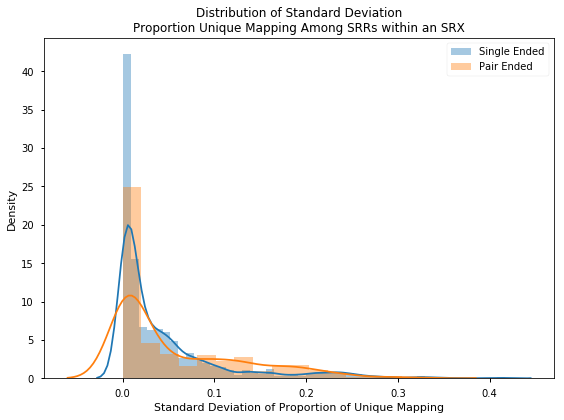

In [13]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_std_unique_mapping'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    from ncbi_remap.flagging import srr_per_srx
    srx_counts = srr_per_srx(store)
    multi_srr_srx = srx_counts[(srx_counts > 1)['srr']].index.tolist()

    se = store['prealn/workflow/hisat2/SE'][['srx', 'srr', 'num_reads', 'num_uniquely_aligned']]
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']
    se = se[se.srx.isin(multi_srr_srx)]

    pe = store['prealn/workflow/hisat2/PE'][['srx', 'srr', 'num_reads', 'num_concordant_reads_uniquely_aligned']]
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']
    pe = pe[pe.srx.isin(multi_srr_srx)]

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Single Ended')
    sns.distplot(pe.groupby('srx')['prop_unique_aligned'].std(), ax=ax, label='Pair Ended')
    ax.legend()
    
    ax.set_title('Distribution of Standard Deviation\nProportion Unique Mapping Among SRRs within an SRX')
    ax.set_xlabel('Standard Deviation of Proportion of Unique Mapping')
    ax.set_ylabel('Density');
    
    return fig

plot(store)

# Sequencing Technology Classification

Next I want to use different feature types to classify data.

## Feature Counts

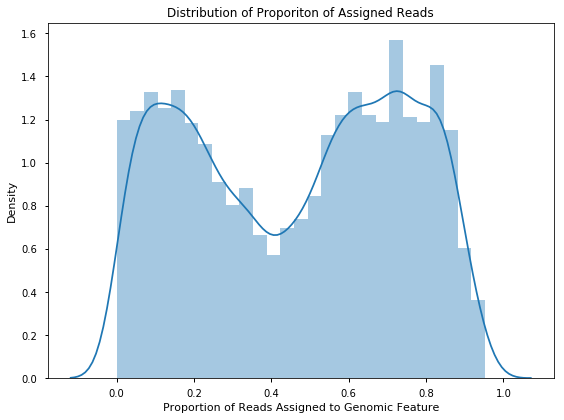

In [30]:
# Plot distribution of proportion assigned reads
@make_figs(nbconfig.fig_name('distplot_prop_assigned_reads'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/feature_counts/summary']
    df.set_index(['srx', 'srr'], inplace=True)
    df['total'] = df.sum(axis=1)
    df['prop_assigned'] = df.Assigned / df.total
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.prop_assigned, ax=ax)
    
    ax.set_title('Distribution of Proporiton of Assigned Reads')
    ax.set_xlabel('Proportion of Reads Assigned to Genomic Feature')
    ax.set_ylabel('Density')
    
    return fig

plot(store)

In [33]:
df = store['prealn/workflow/markduplicates']

In [34]:
df.head()

,srx,srr,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,SRX2581987,SRR5278103,Unknown Library,608397,1777633,718566,30692893,551340,1434660,0,0.821551,344967.0
1,SRX2556775,SRR5251041,Unknown Library,764496,0,72476,1418095,676306,0,0,0.884643,NaN
2,SRX2556774,SRR5251040,Unknown Library,180326,0,19633,604487,128277,0,0,0.711362,NaN
3,SRX2556773,SRR5251039,Unknown Library,841415,0,95391,2022701,728862,0,0,0.866234,NaN
4,SRX2556772,SRR5251038,Unknown Library,639582,0,66892,1925506,534834,0,0,0.836224,NaN


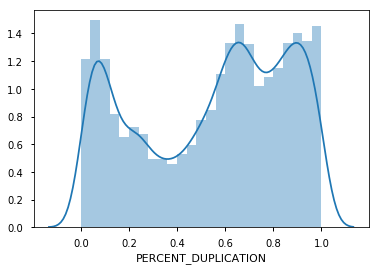

In [35]:
sns.distplot(df.PERCENT_DUPLICATION)

In [32]:
store.root.prealn.workflow.markduplicates

/prealn/workflow/markduplicates (Group) ''
  children := ['table' (Table)]

In [22]:
from ncbi_remap.io import add_id, remove_id

#srx = 'SRX648309'
#srr = 'SRR1509506'

#store.select('prealn/complete', 'srr == {}'.format(srr))
#remove_id(store, 'prealn/complete', srr=srr)
#
#store.select('prealn/complete', 'srr == {}'.format(srr))
#add_id(store, 'prealn/complete', srx=srx, srr=srr)
#
#(store['prealn/complete'].srr == srr).any()